In [372]:
import pydot
import matplotlib.pyplot as plt
import time
import math
import random
from sklearn.manifold import MDS
import numpy as np
import plotly.graph_objs as go
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from sklearn.metrics import euclidean_distances
from collections import OrderedDict


In [373]:
run "Step6.ipynb"

# Testing

### Metrics formulas

In [374]:
def compute_continuity(similarities, distances_Y, k=5):
    
    n = len(similarities)

    nn_orig = similarities.argsort()
    nn_proj = distances_Y.argsort()

    knn_orig = nn_orig[:, :k + 1][:, 1:]
    knn_proj = nn_proj[:, :k + 1][:, 1:]

    sum_i = 0

    for i in range(n):
        V = np.setdiff1d(knn_orig[i], knn_proj[i])

        sum_j = 0
        for j in range(V.shape[0]):
            sum_j += np.where(nn_proj[i] == V[j])[0] - k

        sum_i += sum_j

    return float((1 - (2 / (n * k * (2 * n - 3 * k - 1)) * sum_i)).squeeze())

def compute_trustworthiness(similarities, distances_Y, k=5):
    
    n = len(similarities)

    nn_orig = similarities.argsort()
    nn_proj = distances_Y.argsort()

    knn_orig = nn_orig[:, :k + 1][:, 1:]
    knn_proj = nn_proj[:, :k + 1][:, 1:]

    sum_i = 0

    for i in range(n):
        U = np.setdiff1d(knn_proj[i], knn_orig[i])

        sum_j = 0
        for j in range(U.shape[0]):
            sum_j += np.where(nn_orig[i] == U[j])[0] - k

        sum_i += sum_j

    trustworthiness_score = float((1 - (2 / (n * k * (2 * n - 3 * k - 1)) * sum_i)).squeeze())
    return trustworthiness_score

def compute_stress(similarities, distances_Y):
    
    stress = np.sum((similarities - distances_Y)**2) / np.sum(similarities**2)

    return stress

def compute_shepard(distances, distances_Y):
    
    plt.scatter(distances.flatten(), distances_Y.flatten())
    plt.xlabel('Original Distances')
    plt.ylabel('Transformed Distances')
    plt.title('Shepard Plot')
    plt.show()

### t-sne for testing

In [375]:
def plot_tsne_testing(distances, node_list, edge_list, perplexity=10, learning_rate=30, n_iter=1000):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, init='random', metric='precomputed')
    embeddings = tsne.fit_transform(distances)
    distances_Y = euclidean_distances(embeddings)

    continuity_score = compute_continuity(distances, distances_Y)
    trustworthiness_score = compute_trustworthiness(distances, distances_Y)
    stress = compute_stress(distances, distances_Y)
    shepard_values = compute_shepard(distances, distances_Y)

    print(f"Continuity {continuity_score}")
    print(f"Trustworthiness {trustworthiness_score}")
    print(f"Stress {stress}")

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)

    for edge in edge_list:
        u, v = edge
        u_index = node_list.index(u)
        v_index = node_list.index(v)
        plt.plot([embeddings[u_index, 0], embeddings[v_index, 0]], 
                 [embeddings[u_index, 1], embeddings[v_index, 1]], 
                 color='gray', alpha=0.2)

    for i, node_number in enumerate(node_list):
        plt.text(embeddings[i, 0], embeddings[i, 1], node_number, color='black')

    plt.axis('off')
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()


# Metrics miserables

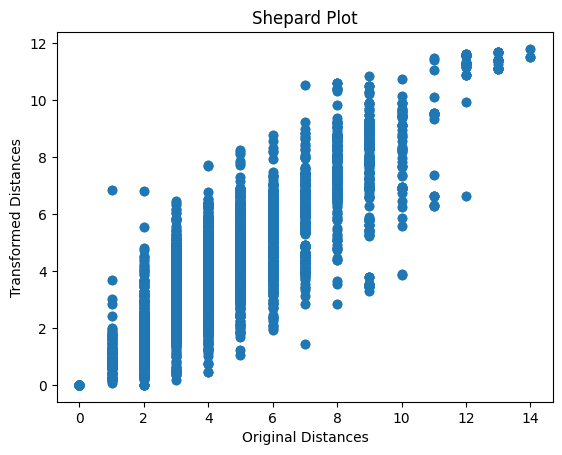

Continuity 0.9248635422548466
Trustworthiness 0.9416149068322981
Stress 0.0695111821818892


/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_60450/4144078157.py:16: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



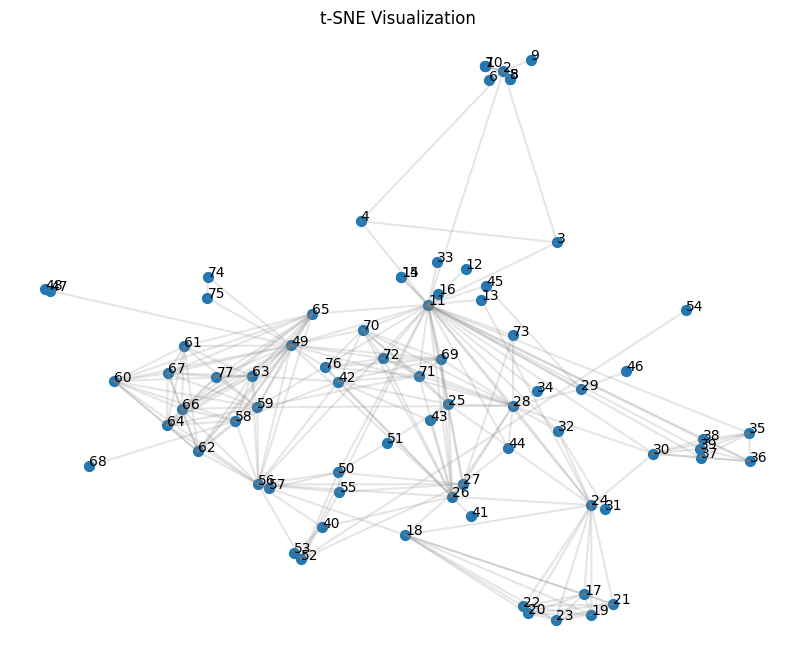

In [376]:
nodes, edges, node_list, edge_list, weights = get_data_step6('Datasets/LesMiserables.dot')
distances = floyd_warshall(node_list, edge_list, weights)
plot_tsne_testing(distances, node_list, edge_list, perplexity=25,learning_rate=100, n_iter=1000)


# Metrics League

In [378]:
def get_data_negative(dot_file_path):
    with open(dot_file_path, 'r') as dot_file:
        dot_data = dot_file.read()

    graph = pydot.graph_from_dot_data(dot_data)

    nodes = graph[0].get_nodes()
    edges = graph[0].get_edges()
    
    node_list = [node.get_name() for node in nodes]
    
    weights = {}
    for edge in edges:
        source = edge.get_source()
        destination = edge.get_destination()
        attributes = edge.get_attributes()
        
        if attributes and "label" in attributes.keys():
            weight_str = attributes["label"]
            
            weight = -int(weight_str.strip('"')) 
            weights[(destination, source)] = weight 

    edge_list = [(edge.get_destination(), edge.get_source()) for edge in edges]

    return nodes, edges, node_list, edge_list, weights

In [379]:
def get_data_zero(dot_file_path):
    with open(dot_file_path, 'r') as dot_file:
        dot_data = dot_file.read()

    graph = pydot.graph_from_dot_data(dot_data)

    nodes = graph[0].get_nodes()
    edges = graph[0].get_edges()
    
    node_list = [node.get_name() for node in nodes]
    edge_list = [(edge.get_source(), edge.get_destination()) for edge in edges]
    
    weights = {(edge.get_source(), edge.get_destination()): 1 for edge in edges}

    return nodes, edges, node_list, edge_list, weights

#nodes, edges, node_list, edge_list, weights = get_data_zero('XZero_LeagueNetwork.dot')
#print("Nodes:", node_list)
#print("Edges:", edge_list)
#print("Weights:", weights)

In [380]:
nodes_neg, edges_neg, node_list_neg, edge_list_neg, weights_neg = get_data_negative('XNeg_LeagueNetwork.dot')
nodes_pos, edges_pos, node_list_pos, edge_list_pos, weights_pos = get_data_step6('XPos_LeagueNetwork.dot')
nodes_z, edges_z, node_list_z, edge_list_z, weights_z = get_data_zero('XZero_LeagueNetwork.dot')

#print(weights_neg)


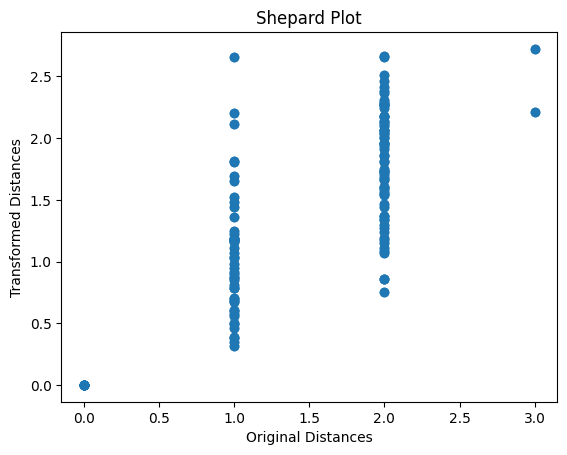

Continuity 0.7765625
Trustworthiness 0.8234375
Stress 0.08832031862276915


/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_60450/1534221791.py:17: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



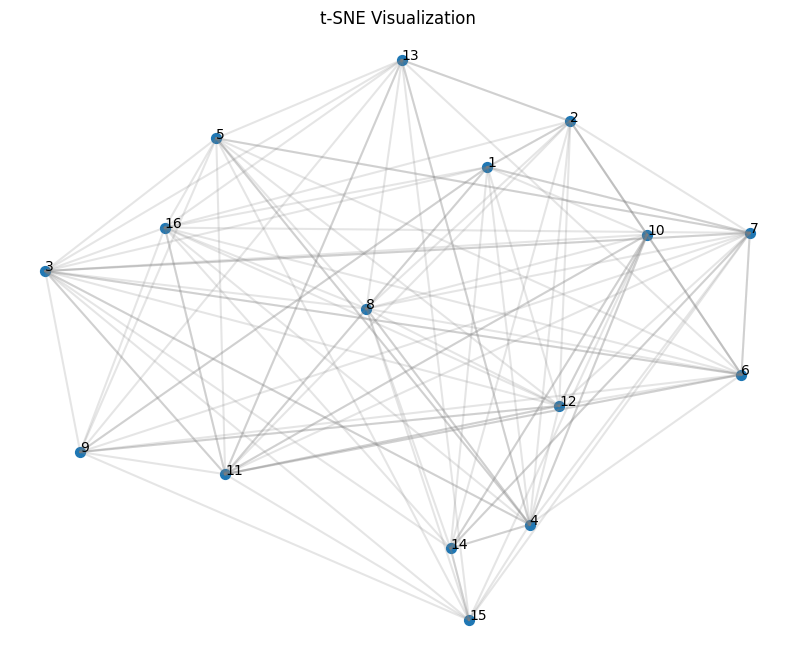

In [381]:
def plot_tsne_testing_league(distances, node_list, edge_list, perplexity=10, learning_rate=30, n_iter=1000):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, init='random', metric="precomputed")
    distances = np.abs(distances)
    embeddings = tsne.fit_transform(distances)
    distances_Y = euclidean_distances(embeddings)

    continuity_score = compute_continuity(distances, distances_Y)
    trustworthiness_score = compute_trustworthiness(distances, distances_Y)
    stress = compute_stress(distances, distances_Y)
    shepard_values = compute_shepard(distances, distances_Y)

    print(f"Continuity {continuity_score}")
    print(f"Trustworthiness {trustworthiness_score}")
    print(f"Stress {stress}")

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)

    for edge in edge_list:
        u, v = edge
        u_index = node_list_neg.index(u)
        v_index = node_list_neg.index(v)
        plt.plot([embeddings[u_index, 0], embeddings[v_index, 0]], 
                 [embeddings[u_index, 1], embeddings[v_index, 1]], 
                 color='gray', alpha=0.2)

    for i, node_number in enumerate(node_list):
        plt.text(embeddings[i, 0], embeddings[i, 1], node_number, color='black')

    plt.axis('off')
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

nodes, edges, node_list, edge_list, weights = get_data_step6('XPos_LeagueNetwork.dot') #change according to subdataset 
distances = floyd_warshall(node_list, edge_list, weights)
plot_tsne_testing_league(distances, node_list, edge_list, perplexity=10,learning_rate=15, n_iter=1000)

# Metrics Jazz

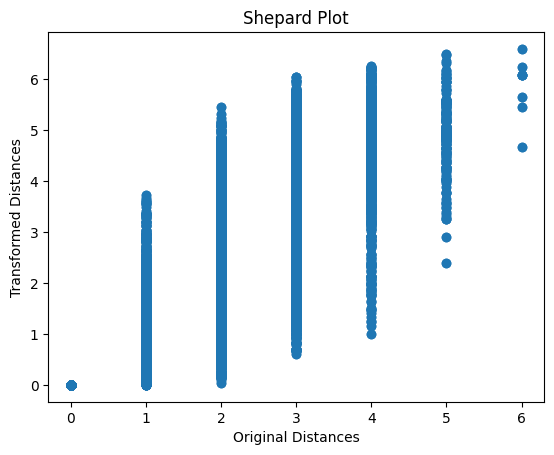

Continuity 0.8723710792131845
Trustworthiness 0.8851727804359384
Stress 0.1765976856241099


/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_60450/4144078157.py:16: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



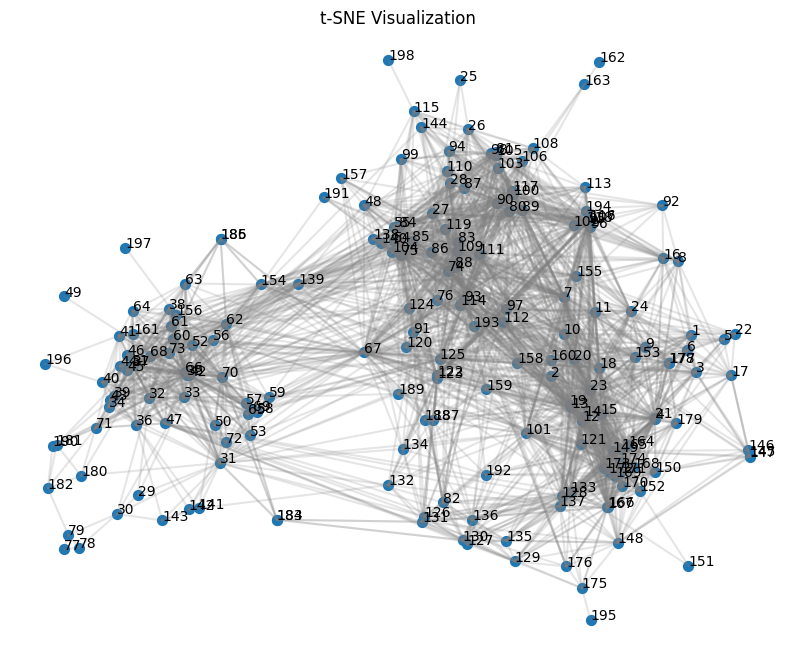

In [383]:
nodes, edges, node_list, edge_list, weights = get_data_jazz('Datasets/Jazznetwork.dot')
distances = floyd_warshall(node_list, edge_list, weights)
plot_tsne_testing(distances, node_list, edge_list, perplexity=90,learning_rate=500, n_iter=1000)